# Frequency Band Analysis of Adversarial Filter 
In this notebook we will run adversarial attacks on a trained model for a given dataset (using ESC-50 for Demo purposes).  
The adversarially generated filters will then be analysed w.r.t. the frequency bands they affect.

In [ ]:
%cd ..
DEVICE = "cuda" # Set to "cpu" if no cuda device available

## Load Model

### CNN14

In [ ]:
from training.cnn14_adv_train import CNN14Adv
CNN14_CHECKPOINT = "./notebooks/cnn14_esc50.ckpt" # Must correspond to model type and dataset

model = CNN14Adv.load_from_checkpoint(CNN14_CHECKPOINT)
if DEVICE == "cpu": # Bugfix
    model.mel.preemphasis_coef = model.mel.preemphasis_coef.cpu()

### PaSST

In [ ]:
from training.passt_adv_train import PasstAdv
PASST_CHECKPOINT = "./notebooks/passt_esc50.ckpt" # Must correspond to model type and dataset

model = PasstAdv.load_from_checkpoint(PASST_CHECKPOINT, map_location=DEVICE)
if DEVICE == "cpu": # Bugfix
    model.mel.preemphasis_coef = model.mel.preemphasis_coef.cpu()

## Load Dataset

### ESC-50

In [5]:
from data.esc50 import ESC50DataModule
ESC50DIR = "../ESC-50/"
BATCH_SIZE = 32 # Set to what your gpu memory can fit
data_module = ESC50DataModule(dir=ESC50DIR, batch_size=BATCH_SIZE, num_workers=1)
data_module.setup("test")
class_map = dict((v, k) for k, v in data_module.class_map.items())
loader = data_module.test_dataloader()
dataset = "ESC-50"
sr = 32000

Loading test folds: 100%|██████████| 400/400 [00:00<00:00, 344855.42it/s]


## Run Attack on complete Test Set

In [60]:
from attacks.filter_pgd import run_pgd_batched
import numpy as np
from tqdm import tqdm
EPSILON = 0.5
ALPHA = EPSILON / 10
filters = []
metadata = []
batch = 0
for samples, labels in tqdm(loader, "Running attacks on batches"):
    x = model.mel(samples.to(DEVICE))
    preds_before = np.argmax(model(x).cpu().detach().numpy(), axis=1)
    res_dict = run_pgd_batched(model, x, labels.to(DEVICE), device=DEVICE,
                              eps=EPSILON, alpha=ALPHA, max_iters=10, restarts=10)
    preds_after = np.argmax(model(res_dict['perturbed_inputs'].to(DEVICE)).cpu().detach().numpy(), axis=1)
    success_idx = np.where(preds_before != preds_after)
    for i in success_idx[0]:
        filters.append(res_dict['filters'][i].cpu().numpy())
        metadata.append({"idx": batch+BATCH_SIZE+i, "pred_before": preds_before[i], "pred_after": preds_after[i]})
    batch += 1

Running attacks on batches: 100%|██████████| 13/13 [01:20<00:00,  6.18s/it]


## Analyse the Filters

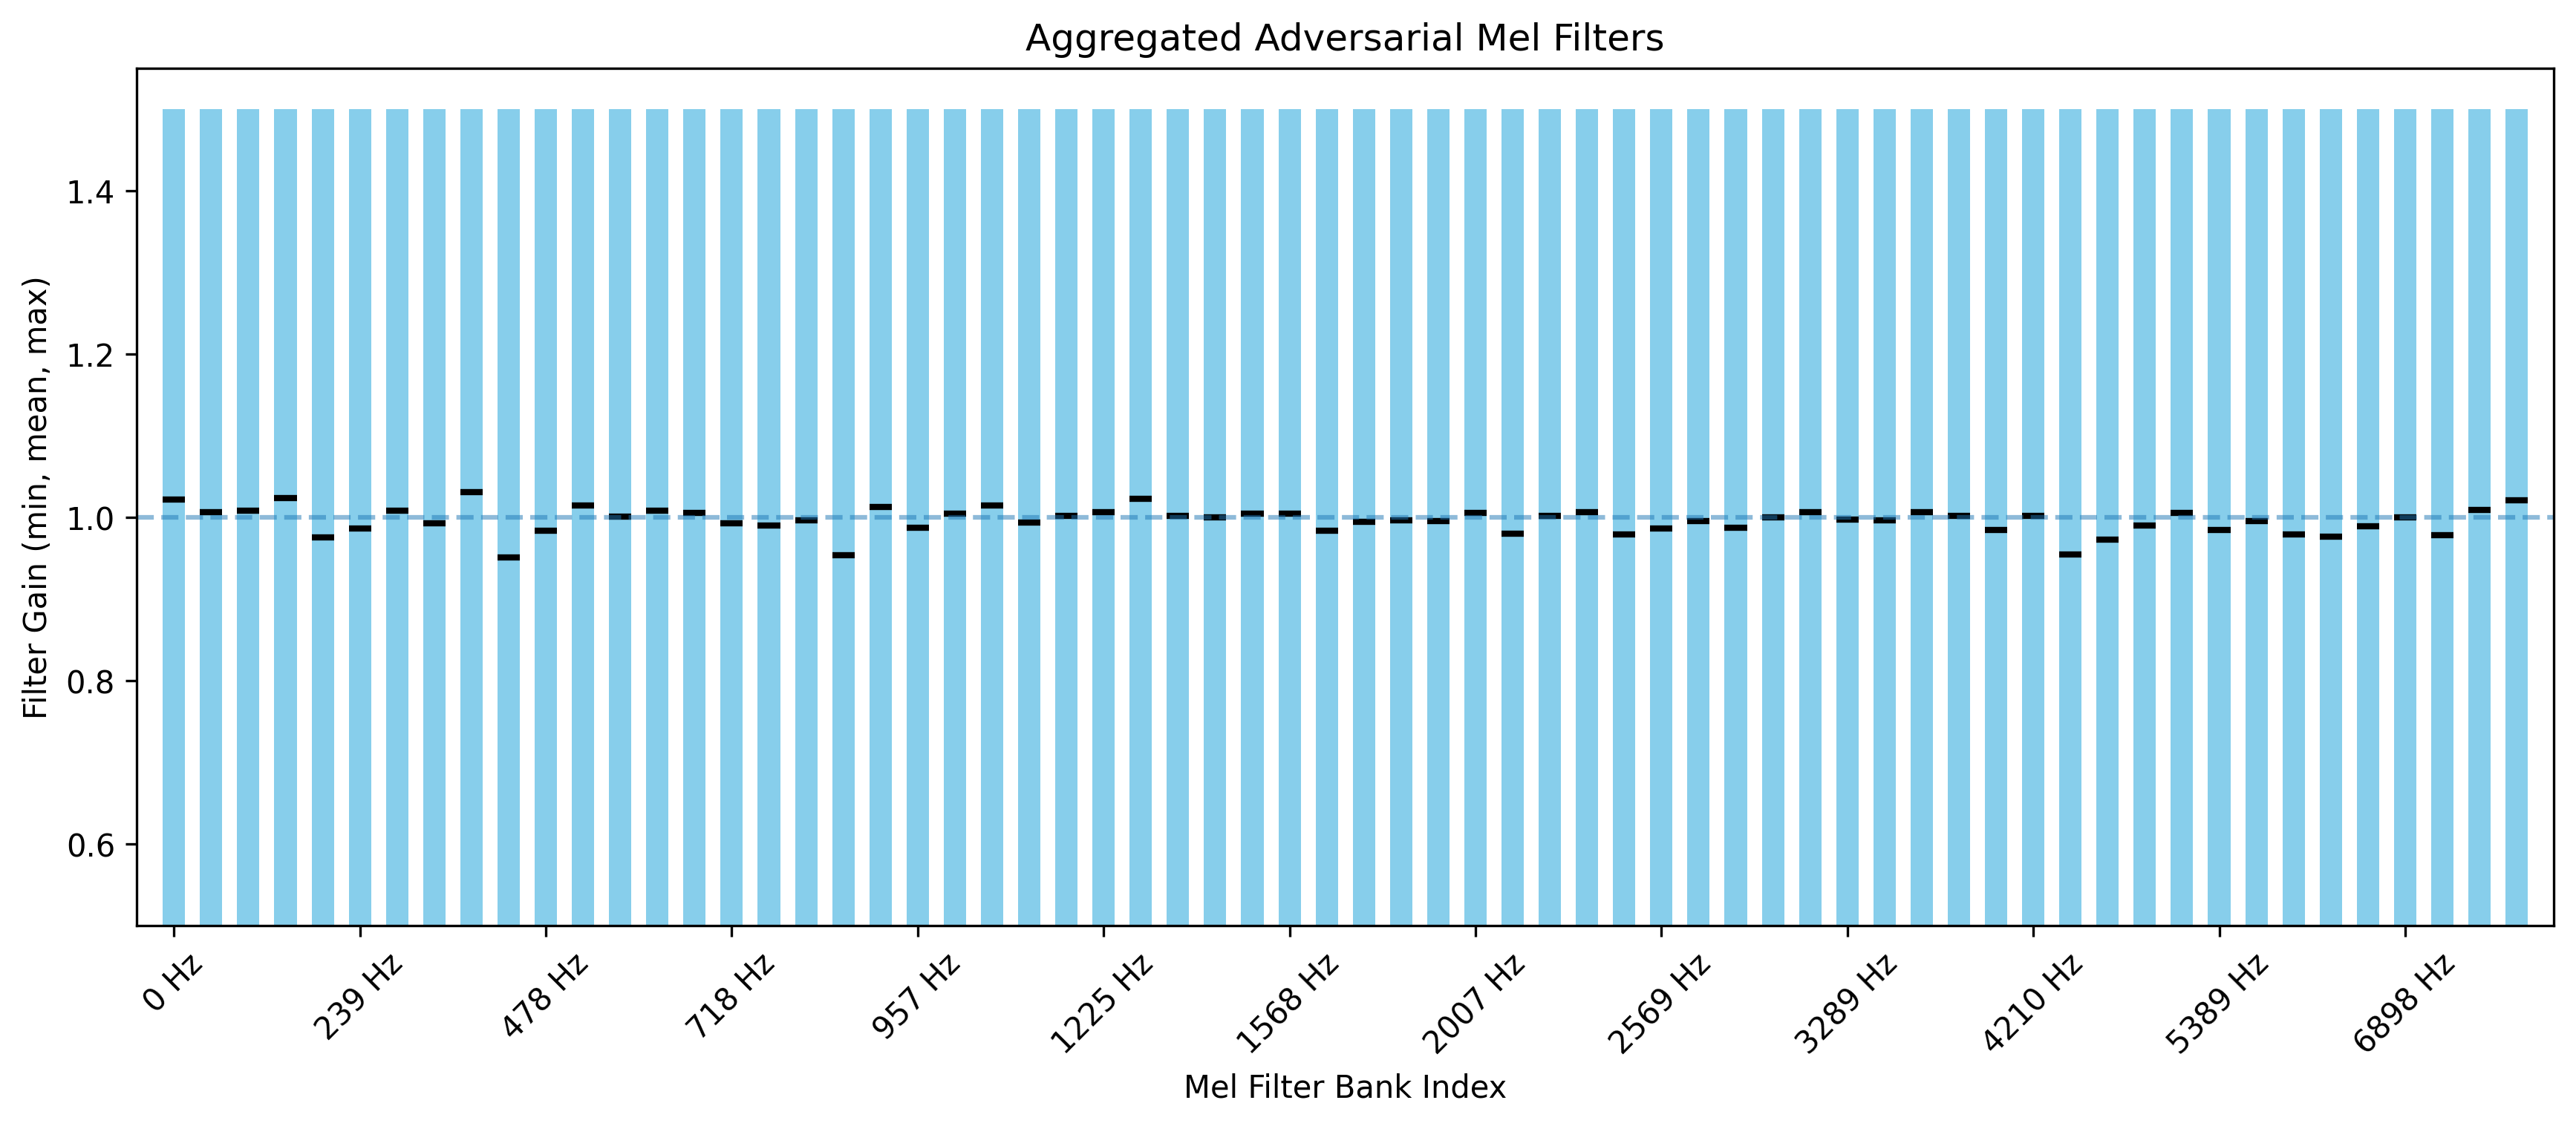

In [61]:
import matplotlib.pyplot as plt
import librosa
# Across all classes
filters = np.array(filters)
def plot_filter_stats(filters, title="Aggregated Adversarial Mel Filters"):
    # Aggregate mean, min, mix
    mean_filter = np.mean(filters, axis=0)
    min_filter = np.min(filters, axis=0)
    max_filter = np.max(filters, axis=0)
    plt.figure(figsize=(14, 5), dpi=300)
    bars = plt.bar(np.arange(len(mean_filter)), max_filter-min_filter, bottom=min_filter, width=0.6, color="skyblue")
    for i, bar in enumerate(bars):
        y = mean_filter[i]
        x_start = bar.get_x()
        x_end = x_start + bar.get_width()
        plt.hlines(y, x_start, x_end, colors='black', linewidth=2)
    # Map indices to mel frequencies
    mel_freqs = librosa.mel_frequencies(n_mels=len(mean_filter), fmin=0, fmax=8000)
    # Set x-ticks to mel frequencies
    xtick_locs = np.arange(0, len(mean_filter), 5)
    xtick_labels = [f"{int(mel_freqs[i])} Hz" for i in xtick_locs]
    plt.xticks(xtick_locs, xtick_labels, rotation=45)
    plt.xlim((-1, len(mean_filter)))
    plt.title(title)
    plt.xlabel("Mel Filter Bank Index")
    plt.ylabel("Filter Gain (min, mean, max)")
    plt.axhline(1, linestyle='--', alpha=0.5)
plot_filter_stats(filters)

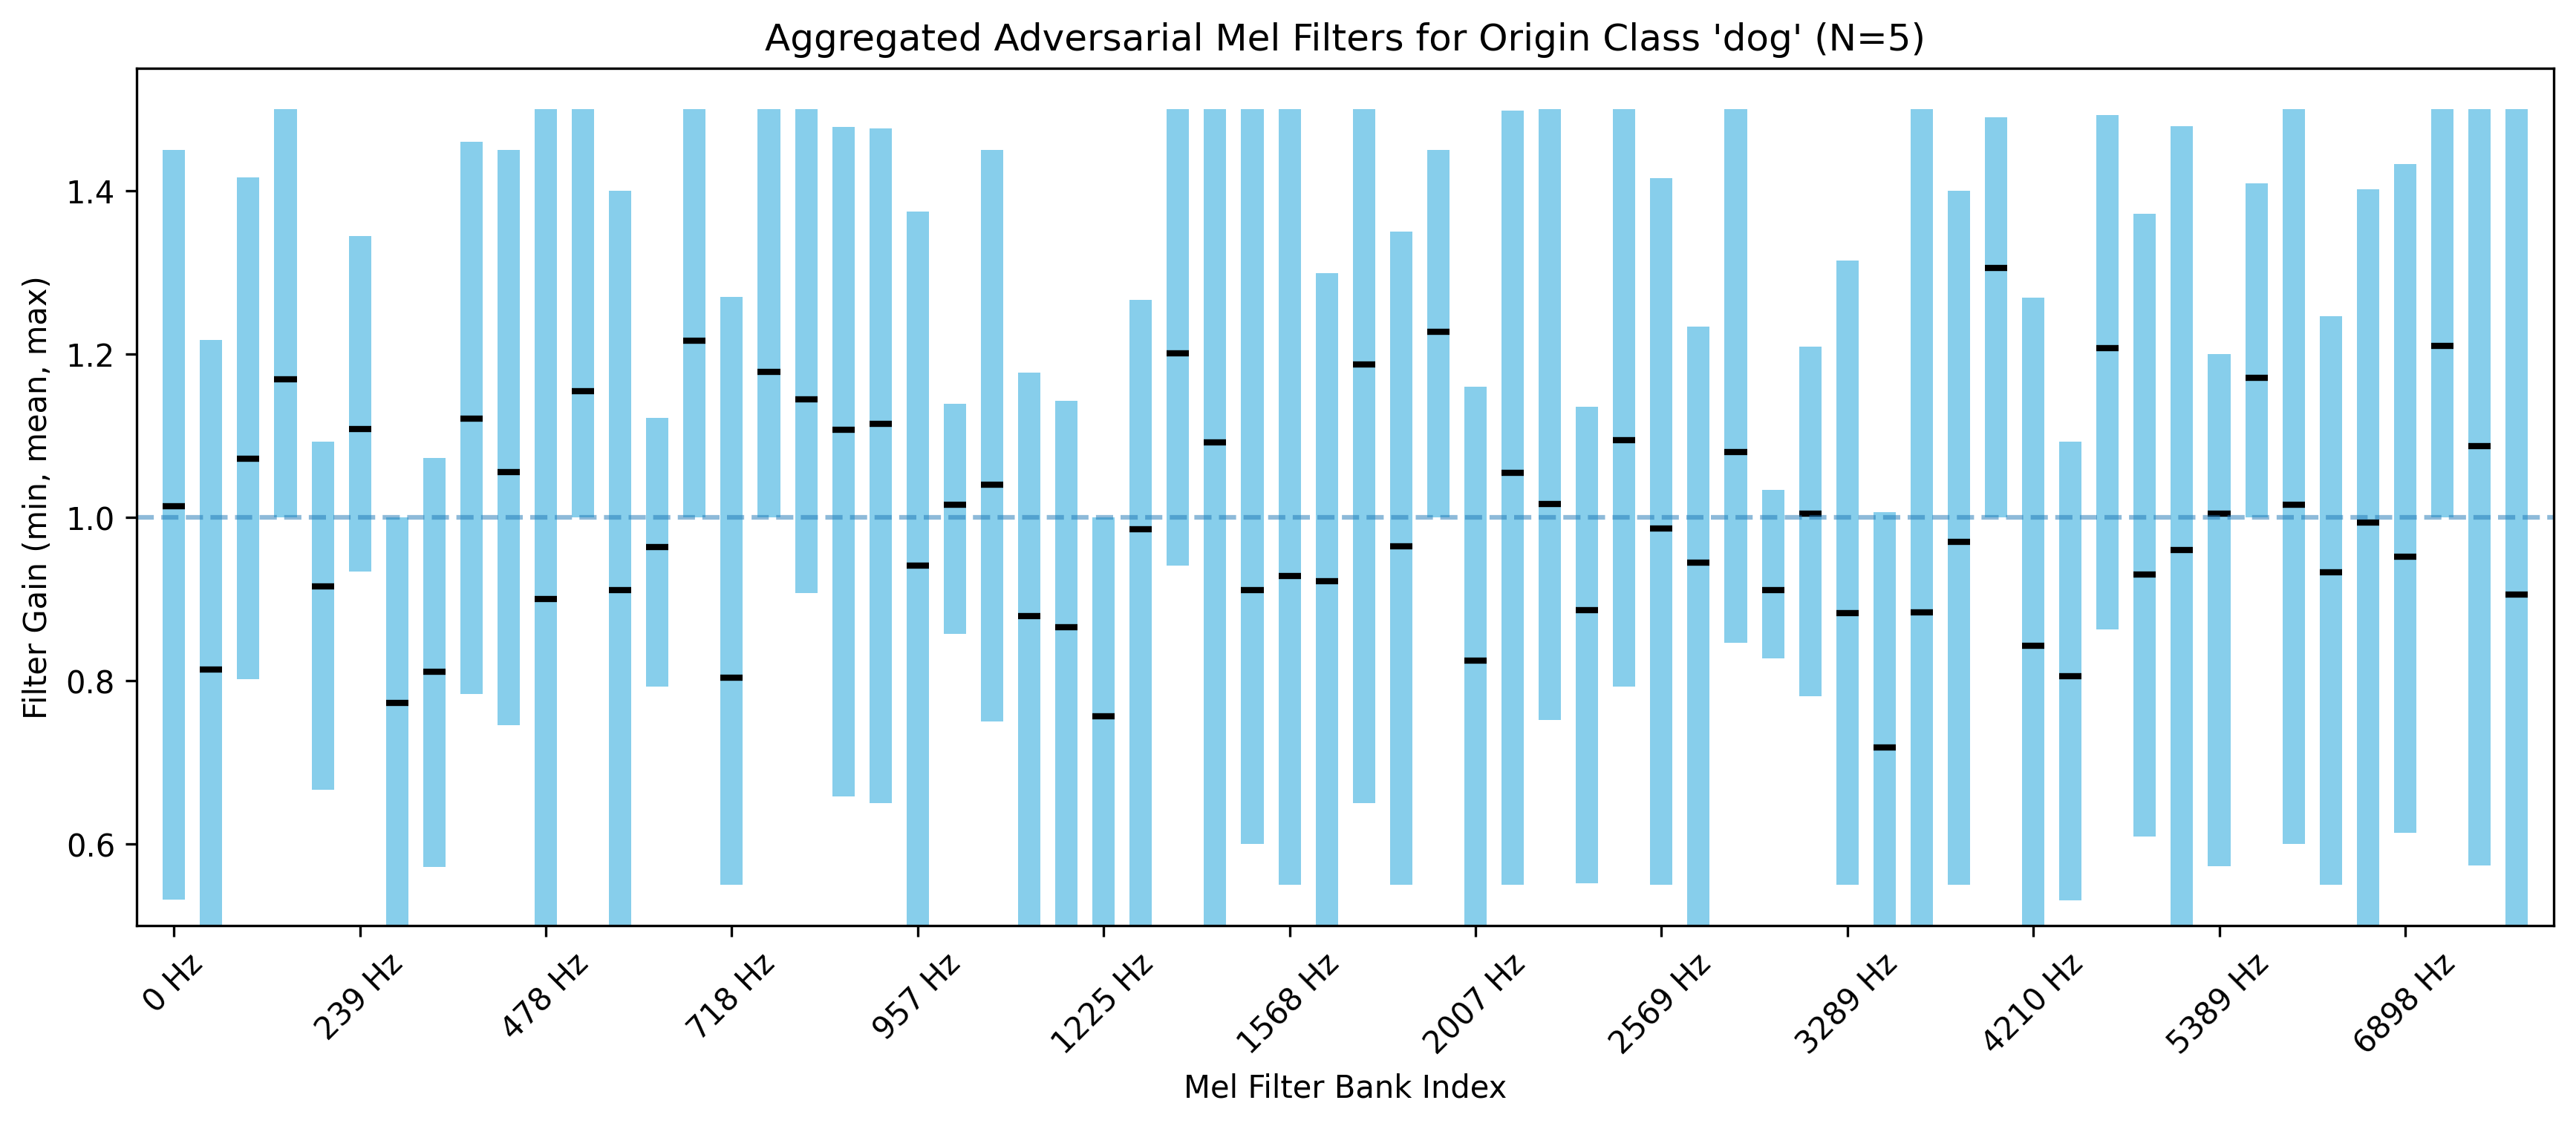

In [66]:
# Class-wise analysis: from class i to class ANY
CLASS_NAME = "dog" # Change to desired class name
class_idx = class_map[CLASS_NAME]
class_filters = [filters[i] for i in range(len(filters)) if metadata[i]['pred_before'] == class_idx]
if class_filters:
    plot_filter_stats(class_filters, title=f"Aggregated Adversarial Mel Filters for Origin Class '{CLASS_NAME}' (N={len(class_filters)})")
else:
    print(f"No filters found for origin class {CLASS_NAME})")

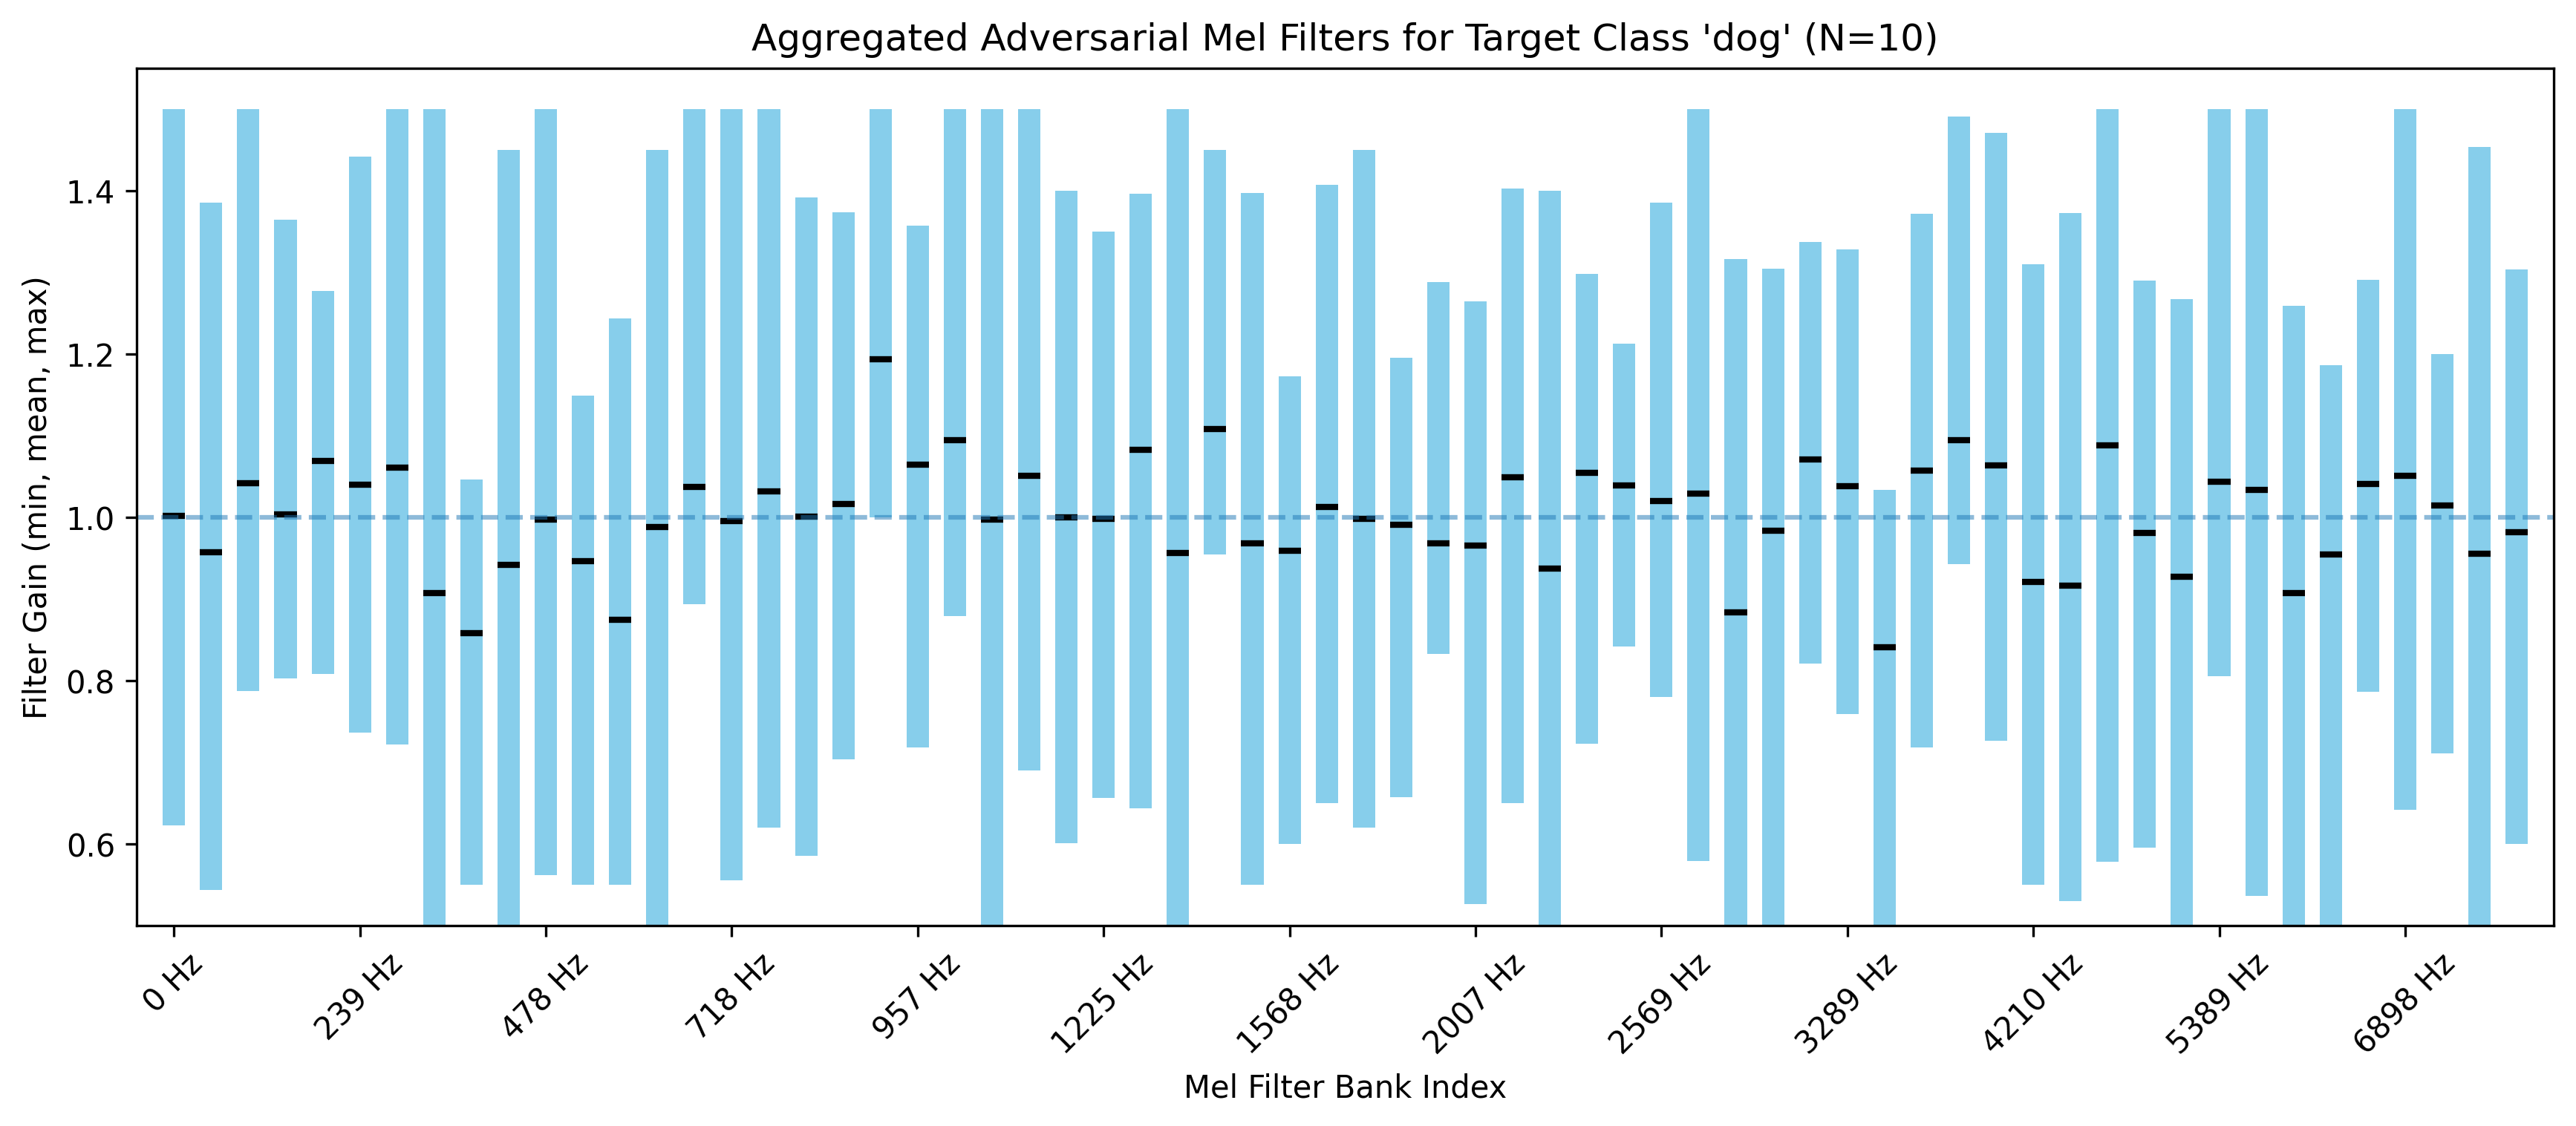

In [67]:
# Class-wise analysis: from class ANY to class i
CLASS_NAME = "dog" # Change to desired class name
class_idx = class_map[CLASS_NAME]
class_filters = [filters[i] for i in range(len(filters)) if metadata[i]['pred_after'] == class_idx]
if class_filters:
    plot_filter_stats(class_filters, title=f"Aggregated Adversarial Mel Filters for Target Class '{CLASS_NAME}' (N={len(class_filters)})")
else:
    print(f"No filters found for target class {CLASS_NAME}")

In [68]:
# Class-wise analysis: from class i to class j
CLASS_NAME_I = "dog"
CLASS_NAME_J = "cat"
class_idx_i = class_map[CLASS_NAME_I] # Change to desired origin class index
class_idx_j = class_map[CLASS_NAME_J]   # Change to desired target class index
class_filters = [filters[i] for i in range(len(filters)) if metadata[i]['pred_before'] == class_idx_i and metadata[i]['pred_after'] == class_idx_j]
if class_filters:
    plot_filter_stats(class_filters, title=f"Aggregated Adversarial Mel Filters for Origin: {CLASS_NAME_I}, Target '{CLASS_NAME_J}' (N={len(class_filters)})")
else:
    print("No filters found for this class combination.")

No filters found for this class combination.


### Analysis Comments
Throughout our work we unfortunately were unable to get much insight from this type of analysis.  
It appears that the filters do not follow a particular trend or shape (such as high- or low-pass), but rather amplify or attenuate frequencies without a clear pattern.  
As mentioned in our paper, a future extension of our work might be to reduce the number of filter bands which may lead to overall more insightful filters that make such an analysis more meaningful.